In [5]:
# =============================
# 1. Import Libraries
# =============================
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import seaborn as sns

In [6]:
# =============================
# 2. Constants
# =============================
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 15

In [7]:
# =============================
# 3. Load Dataset
# =============================
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '../detect_data',   # path to dataset folder
    seed=124,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
class_names = dataset.class_names
print("Classes:", class_names)

Found 3065 files belonging to 2 classes.
Classes: ['non_potato_leaves', 'potato_leaves']


In [9]:
# =============================
# 4. Train/Validation/Test Split
# =============================
def partition_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + val_split + test_split) == 1
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(ds_size * train_split)
    val_size   = int(ds_size * val_split)

    train_ds = ds.take(train_size)
    val_ds   = ds.skip(train_size).take(val_size)
    test_ds  = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = partition_dataset(dataset)

# Optimize performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds   = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds  = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
# =============================
# 5. Data Preprocessing & Augmentation
# =============================
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])


In [11]:
# =============================
# 6. Handle Class Imbalance
# =============================
labels = []
for _, y in dataset.unbatch():
    labels.append(y.numpy())

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(0.6217038539553753), 1: np.float64(2.5541666666666667)}


In [12]:
# =============================
# 7. Build Transfer Learning Model
# =============================
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model.trainable = False  # freeze base model

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")  # Binary classification
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

C:\Users\MRINMAY\AppData\Local\Temp\ipykernel_5652\21350240.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
# =============================
# 8. Train Model
# =============================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    verbose=1
)


Epoch 1/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.6573 - loss: 0.6889 - precision: 0.2874 - recall: 0.5042 - val_accuracy: 0.7083 - val_loss: 0.5808 - val_precision: 0.3604 - val_recall: 0.7547
Epoch 2/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7006 - loss: 0.6004 - precision: 0.3573 - recall: 0.6576 - val_accuracy: 0.7361 - val_loss: 0.5397 - val_precision: 0.3905 - val_recall: 0.7736
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7332 - loss: 0.5501 - precision: 0.4009 - recall: 0.7269 - val_accuracy: 0.7674 - val_loss: 0.4894 - val_precision: 0.4255 - val_recall: 0.7547
Epoch 4/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7629 - loss: 0.5309 - precision: 0.4384 - recall: 0.7395 - val_accuracy: 0.7847 - val_loss: 0.4528 - val_precision: 0.4494 - val_recall: 0.7547
Epoch 5/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7905 - loss: 0.4715 - precision: 0.4793 - recall: 0.7794 - val_accuracy: 0.8125 - val_loss: 0.4147 - va

In [20]:
# =============================
# 9. Fine-Tuning
# =============================
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.9480 - loss: 0.1405 - precision_3: 0.8182 - recall_3: 0.9454 - val_accuracy: 0.9306 - val_loss: 0.3928 - val_precision_3: 0.8511 - val_recall_3: 0.7547
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.9522 - loss: 0.1281 - precision_3: 0.8346 - recall_3: 0.9433 - val_accuracy: 0.9271 - val_loss: 0.4113 - val_precision_3: 0.7963 - val_recall_3: 0.8113
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.9493 - loss: 0.1280 - precision_3: 0.8250 - recall_3: 0.9412 - val_accuracy: 0.9236 - val_loss: 0.4236 - val_precision_3: 0.7719 - val_recall_3: 0.8302
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.9563 - loss: 0.1196 - precision_3: 0.8426 - recall_3: 0.9559 - val_accuracy: 0.9271 - val_loss: 0.4134 - val_precision_3: 0.7963 - val_recall_3: 0.8113
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.9551 - loss: 0.1023 - precision_3: 0.8379 - recall_3: 0.9559 - val_accur

11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9062 - loss: 0.4573 - precision_3: 0.7564 - recall_3: 0.8082
Test Accuracy: 90.62%
Precision: 0.76
Recall: 0.81
F1-score: 0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step


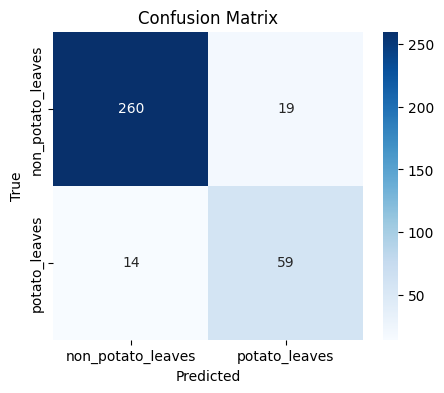

                   precision    recall  f1-score   support

non_potato_leaves       0.95      0.93      0.94       279
    potato_leaves       0.76      0.81      0.78        73

         accuracy                           0.91       352
        macro avg       0.85      0.87      0.86       352
     weighted avg       0.91      0.91      0.91       352



In [21]:
# =============================
# 10. Evaluation
# =============================
loss, acc, precision, recall = model.evaluate(test_ds)
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
f1 = 2 * (precision * recall) / (precision + recall)
print(f"F1-score: {f1:.2f}")

# Confusion Matrix
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend([1 if p > 0.5 else 0 for p in preds])

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

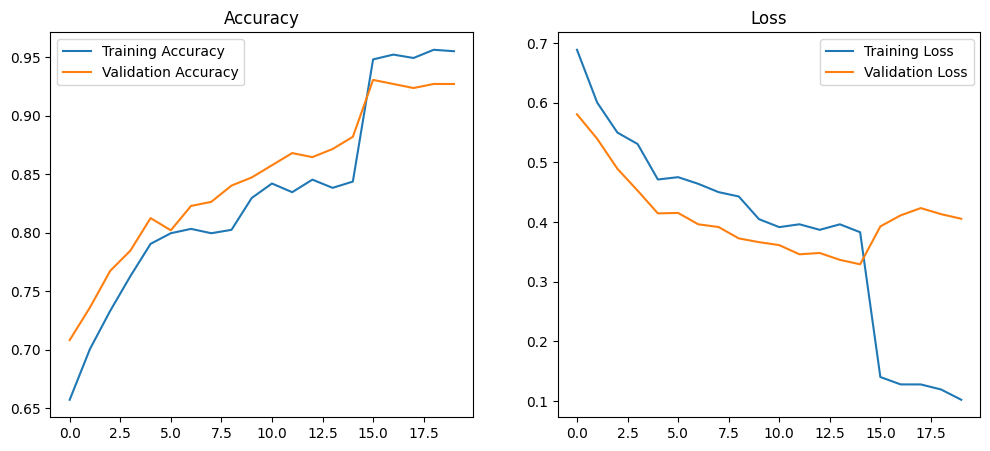

In [22]:
# =============================
# 11. Plot Training Curves
# =============================
acc = history.history["accuracy"] + history_finetune.history["accuracy"]
val_acc = history.history["val_accuracy"] + history_finetune.history["val_accuracy"]
loss = history.history["loss"] + history_finetune.history["loss"]
val_loss = history.history["val_loss"] + history_finetune.history["val_loss"]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.show()

In [26]:
# =============================
# 12. Prediction on New Image
# =============================
from tensorflow.keras.preprocessing import image

img_path = "../leaves_data/non_potato_leaves/009d3d05-f588-4500-8b66-28b2e60a4e00___CREC_HLB 4541.JPG"  # change path
img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

prediction = model.predict(img_array)
if prediction[0][0] > 0.5:
    print("Prediction: Non-Potato Leaf 🌿❌")
else:
    print("Prediction: Potato Leaf 🥔✅")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction: Potato Leaf 🥔✅
